# Read .bdf files and convert to .h5
For import to MATLAB and Python
Script performs the following:
- Read .bdf file
- Select only EEG channels/discard EOG, EMG
- Reference to the common average
- Filter DC offset and 50hz notch
- Clip off the noisy end of data
- Export to .h5

In [1]:
import os
import numpy as np
import mne
import pathlib
import matplotlib.pyplot as plt

In [2]:
path=pathlib.Path('/media/tris/tris_files/DEAP_dataset/data_original')
path

PosixPath('/media/tris/tris_files/DEAP_dataset/data_original')

In [3]:
raw=mne.io.read_raw_bdf(path/'s04.bdf')
raw.load_data()

Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s04.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1690111  =      0.000 ...  3300.998 secs...


<RawEDF | s04.bdf, 48 x 1690112 (3301.0 s), ~619.0 MB, data loaded>

In [4]:
eeg_channels=raw.ch_names[0:32] #first 32 channels are the EEG ones
eeg_channels

['Fp1',
 'AF3',
 'F7',
 'F3',
 'FC1',
 'FC5',
 'T7',
 'C3',
 'CP1',
 'CP5',
 'P7',
 'P3',
 'Pz',
 'PO3',
 'O1',
 'Oz',
 'O2',
 'PO4',
 'P4',
 'P8',
 'CP6',
 'CP2',
 'C4',
 'T8',
 'FC6',
 'FC2',
 'F4',
 'F8',
 'AF4',
 'Fp2',
 'Fz',
 'Cz']

In [5]:
eog_channels=raw.ch_names[32:36];eog_channels

['EXG1', 'EXG2', 'EXG3', 'EXG4']

In [6]:
emg_channels=raw.ch_names[36:40];emg_channels

['EXG5', 'EXG6', 'EXG7', 'EXG8']

In [7]:
raw.pick_channels(eeg_channels) #select only the EEG channels

<RawEDF | s04.bdf, 32 x 1690112 (3301.0 s), ~412.7 MB, data loaded>

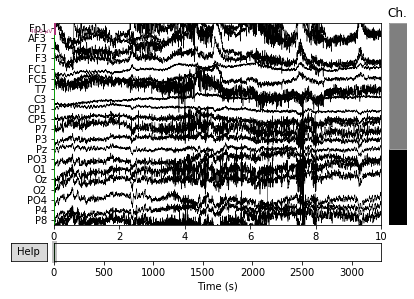

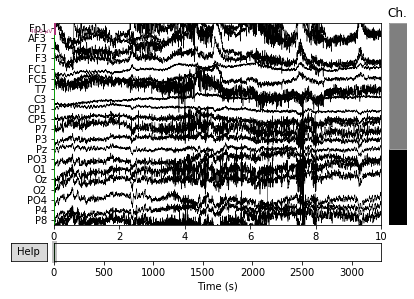

In [8]:
raw.plot()

In [9]:
raw.set_eeg_reference(ref_channels=['Cz']) #reference to the Cz node, common for biosig

EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawEDF | s04.bdf, 32 x 1690112 (3301.0 s), ~412.7 MB, data loaded>

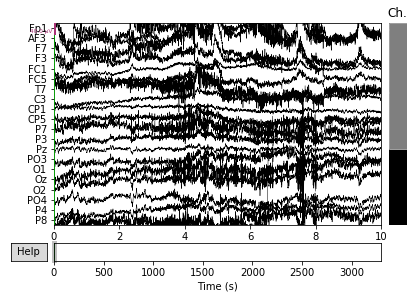

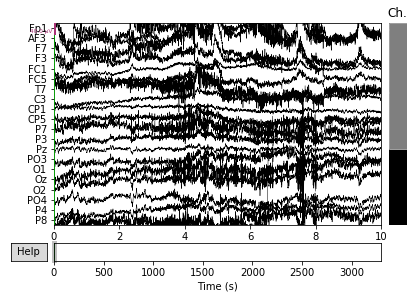

In [10]:
raw.plot()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


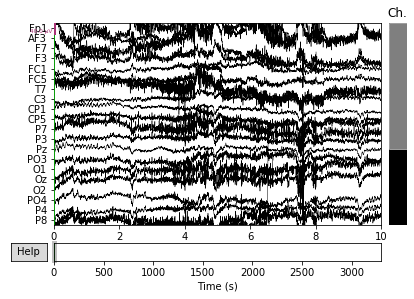

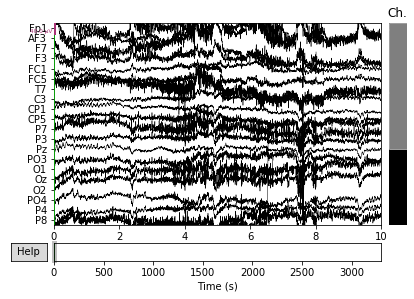

In [11]:
raw_avg=raw.copy().set_eeg_reference(ref_channels='average') #reference to the average (I think is more stable)
raw_avg.plot()

Effective window size : 4.000 (s)


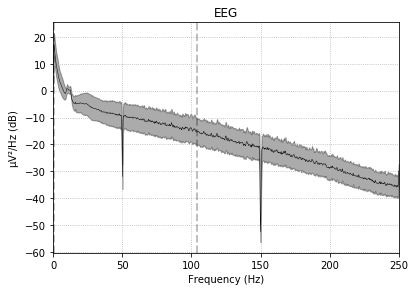

In [17]:
fig = raw_avg.plot_psd(tmax=np.inf, fmax=250, average=True) #check orginal PSD

In [18]:
ssp_projectors = raw.info['projs']
raw.del_proj()

<RawEDF | s04.bdf, 32 x 1690112 (3301.0 s), ~412.7 MB, data loaded>

In [19]:
raw_avg.notch_filter(50,picks=eeg_channels)
raw_avg.notch_filter(150,picks=eeg_channels)
raw_avg.filter(0.5,None, fir_design='firwin')

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 149.12
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 148.88 Hz)
- Upper passband edge: 150.88 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequ

<RawEDF | s04.bdf, 32 x 1690112 (3301.0 s), ~412.7 MB, data loaded>

Effective window size : 4.000 (s)


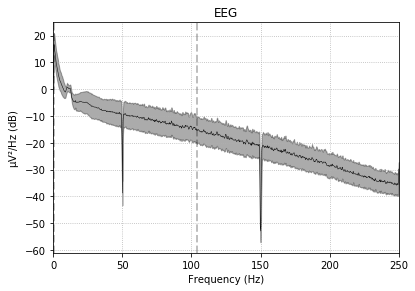

In [20]:
fig = raw_avg.plot_psd(tmax=np.inf, fmax=250, average=True) #check orginal PSD

Effective window size : 4.000 (s)


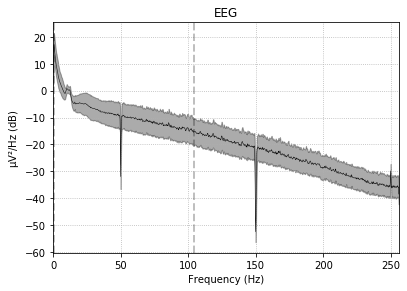

In [16]:
avg_psd=raw_avg.plot_psd(average=True)

Effective window size : 8.000 (s)


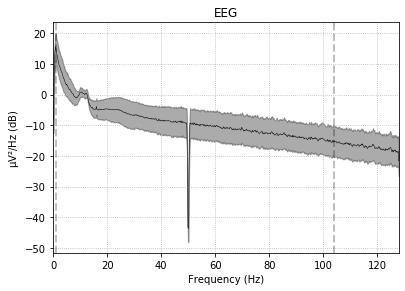

In [18]:
raw_avg_downsampled = raw_avg.copy().resample(sfreq=256) #check downsample PSD
fig=raw_avg_downsampled.plot_psd(average=True)

Effective window size : 8.000 (s)


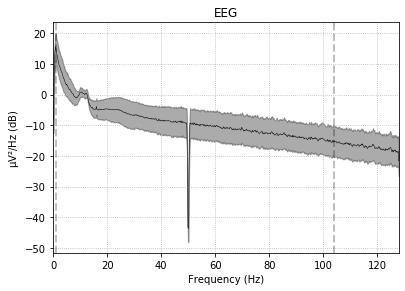

In [19]:
raw_avg_downsampled2 = raw_avg.copy().resample(sfreq=128) #check downsample PSD
avg_psd_128=raw_avg_downsampled.plot_psd(average=True)

In [21]:
df=raw_avg.to_data_frame(scalings=1e6) #convert to pandas
df.head()

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,0,-6.776264e-15,-8.470329e-15,0.000000,-1.694066e-15,4.870439e-15,-6.352747e-15,-4.235165e-16,4.235165e-15,0.000000,...,3.388132e-15,-8.470329e-16,-1.694066e-15,8.470329e-16,5.505714e-15,-2.541099e-15,3.811648e-15,1.694066e-15,8.470329e-16,3.388132e-15
1,2,-5.960176e-01,-6.870556e+00,3.314295,2.045063e+00,-3.398310e-01,5.025773e+00,5.134904e+00,1.814595e+00,0.226346,...,-9.170905e-01,-1.408995e-01,-1.604167e+00,-9.162511e-01,-1.342191e+00,-3.196025e+00,-4.956818e+00,-5.327699e+00,1.999763e-01,-1.055092e+00
2,4,-3.556770e+00,-5.751907e+00,5.055018,3.497772e+00,9.464854e-02,6.182579e+00,5.986299e+00,2.739347e+00,1.306141,...,-2.389135e+00,-4.869956e+00,-1.492606e+00,-9.257104e-01,-8.162345e-01,-2.451618e+00,-5.849859e+00,-8.701367e+00,1.664011e-01,-1.459934e+00
3,6,-1.054183e+01,-1.814537e+00,3.125480,2.897739e+00,-8.762442e-02,4.876630e+00,6.627896e+00,2.447523e+00,0.480750,...,-1.961393e+00,-7.056489e+00,-4.461287e-01,-1.755909e+00,-2.688035e+00,-1.574378e+00,-6.100977e+00,-1.158781e+01,-1.347061e+00,-1.386293e+00
4,8,-1.928210e+01,1.130886e+00,1.695938,2.644040e+00,5.869607e-01,5.570071e+00,8.200034e+00,2.232045e+00,-0.797922,...,-1.001576e+00,-2.044127e+00,1.009409e+00,-2.215592e+00,-3.376323e+00,-1.182424e+00,-4.553094e+00,-1.187328e+01,-1.862451e+00,-1.144016e+00


In [22]:
fs=512
stop_time=len(df)/(fs*60)

In [23]:
df['time']=np.linspace(0,stop_time,num=len(df))

In [24]:
df.head()

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,0.000000,-6.776264e-15,-8.470329e-15,0.000000,-1.694066e-15,4.870439e-15,-6.352747e-15,-4.235165e-16,4.235165e-15,0.000000,...,3.388132e-15,-8.470329e-16,-1.694066e-15,8.470329e-16,5.505714e-15,-2.541099e-15,3.811648e-15,1.694066e-15,8.470329e-16,3.388132e-15
1,0.000033,-5.960176e-01,-6.870556e+00,3.314295,2.045063e+00,-3.398310e-01,5.025773e+00,5.134904e+00,1.814595e+00,0.226346,...,-9.170905e-01,-1.408995e-01,-1.604167e+00,-9.162511e-01,-1.342191e+00,-3.196025e+00,-4.956818e+00,-5.327699e+00,1.999763e-01,-1.055092e+00
2,0.000065,-3.556770e+00,-5.751907e+00,5.055018,3.497772e+00,9.464854e-02,6.182579e+00,5.986299e+00,2.739347e+00,1.306141,...,-2.389135e+00,-4.869956e+00,-1.492606e+00,-9.257104e-01,-8.162345e-01,-2.451618e+00,-5.849859e+00,-8.701367e+00,1.664011e-01,-1.459934e+00
3,0.000098,-1.054183e+01,-1.814537e+00,3.125480,2.897739e+00,-8.762442e-02,4.876630e+00,6.627896e+00,2.447523e+00,0.480750,...,-1.961393e+00,-7.056489e+00,-4.461287e-01,-1.755909e+00,-2.688035e+00,-1.574378e+00,-6.100977e+00,-1.158781e+01,-1.347061e+00,-1.386293e+00
4,0.000130,-1.928210e+01,1.130886e+00,1.695938,2.644040e+00,5.869607e-01,5.570071e+00,8.200034e+00,2.232045e+00,-0.797922,...,-1.001576e+00,-2.044127e+00,1.009409e+00,-2.215592e+00,-3.376323e+00,-1.182424e+00,-4.553094e+00,-1.187328e+01,-1.862451e+00,-1.144016e+00


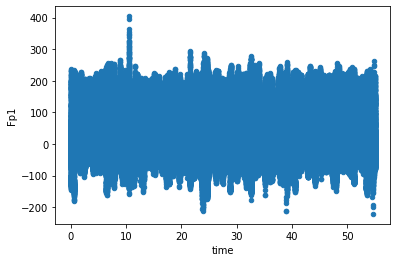

In [25]:
df.plot.scatter(x='time', y='Fp1')

In [26]:
df=df.iloc[0:60*60*512][:] #downsample to clip last couple minutes (noisy))

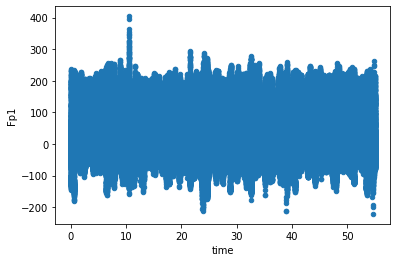

In [27]:
df.plot.scatter(x='time', y='Fp1')

In [28]:
df

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,0.000000,-6.776264e-15,-8.470329e-15,0.000000e+00,-1.694066e-15,4.870439e-15,-6.352747e-15,-4.235165e-16,4.235165e-15,0.000000,...,3.388132e-15,-8.470329e-16,-1.694066e-15,8.470329e-16,5.505714e-15,-2.541099e-15,3.811648e-15,1.694066e-15,8.470329e-16,3.388132e-15
1,0.000033,-5.960176e-01,-6.870556e+00,3.314295e+00,2.045063e+00,-3.398310e-01,5.025773e+00,5.134904e+00,1.814595e+00,0.226346,...,-9.170905e-01,-1.408995e-01,-1.604167e+00,-9.162511e-01,-1.342191e+00,-3.196025e+00,-4.956818e+00,-5.327699e+00,1.999763e-01,-1.055092e+00
2,0.000065,-3.556770e+00,-5.751907e+00,5.055018e+00,3.497772e+00,9.464854e-02,6.182579e+00,5.986299e+00,2.739347e+00,1.306141,...,-2.389135e+00,-4.869956e+00,-1.492606e+00,-9.257104e-01,-8.162345e-01,-2.451618e+00,-5.849859e+00,-8.701367e+00,1.664011e-01,-1.459934e+00
3,0.000098,-1.054183e+01,-1.814537e+00,3.125480e+00,2.897739e+00,-8.762442e-02,4.876630e+00,6.627896e+00,2.447523e+00,0.480750,...,-1.961393e+00,-7.056489e+00,-4.461287e-01,-1.755909e+00,-2.688035e+00,-1.574378e+00,-6.100977e+00,-1.158781e+01,-1.347061e+00,-1.386293e+00
4,0.000130,-1.928210e+01,1.130886e+00,1.695938e+00,2.644040e+00,5.869607e-01,5.570071e+00,8.200034e+00,2.232045e+00,-0.797922,...,-1.001576e+00,-2.044127e+00,1.009409e+00,-2.215592e+00,-3.376323e+00,-1.182424e+00,-4.553094e+00,-1.187328e+01,-1.862451e+00,-1.144016e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690107,55.016536,9.135072e-01,1.342938e+01,8.497659e+00,1.147078e+00,2.225229e-01,-7.160682e+00,-1.632061e+01,-3.546169e+00,-2.005370,...,-4.342571e-01,1.987389e+01,3.166293e+00,3.079956e+00,6.509510e+00,-3.622766e+00,-7.096285e+00,2.876275e+01,4.043425e+00,3.267938e+00
1690108,55.016569,-2.256932e+01,1.095907e+01,4.032198e+00,6.920838e+00,1.513489e+00,-5.095893e+00,-1.163352e+01,-1.013126e+00,-0.318001,...,-2.037291e+00,-2.199647e-01,5.939134e+00,2.203725e+00,6.838611e+00,-2.535395e+00,7.744142e-01,2.373668e+01,3.475113e+00,2.949748e+00
1690109,55.016602,-3.715293e+01,5.504295e+00,3.844988e+00,7.021239e+00,2.314300e+00,-2.787521e+00,4.054480e-01,2.452279e-01,0.896613,...,-3.141450e-03,-1.668180e+01,8.249593e+00,1.694067e+00,4.832036e+00,-2.418670e-01,1.981675e+00,1.394428e+01,2.837098e+00,1.317297e+00
1690110,55.016634,-2.306715e+01,6.353038e+00,3.397909e+00,-1.036393e+00,1.122836e+00,-1.431367e+00,4.053839e+00,2.395423e-03,0.752404,...,1.215329e+00,-1.758414e+01,5.626967e+00,1.226215e-01,1.467963e+00,-5.111556e-01,2.598126e-01,1.744962e+00,1.366524e+00,4.548879e-02


In [29]:
df

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,0.000000,-6.776264e-15,-8.470329e-15,0.000000e+00,-1.694066e-15,4.870439e-15,-6.352747e-15,-4.235165e-16,4.235165e-15,0.000000,...,3.388132e-15,-8.470329e-16,-1.694066e-15,8.470329e-16,5.505714e-15,-2.541099e-15,3.811648e-15,1.694066e-15,8.470329e-16,3.388132e-15
1,0.000033,-5.960176e-01,-6.870556e+00,3.314295e+00,2.045063e+00,-3.398310e-01,5.025773e+00,5.134904e+00,1.814595e+00,0.226346,...,-9.170905e-01,-1.408995e-01,-1.604167e+00,-9.162511e-01,-1.342191e+00,-3.196025e+00,-4.956818e+00,-5.327699e+00,1.999763e-01,-1.055092e+00
2,0.000065,-3.556770e+00,-5.751907e+00,5.055018e+00,3.497772e+00,9.464854e-02,6.182579e+00,5.986299e+00,2.739347e+00,1.306141,...,-2.389135e+00,-4.869956e+00,-1.492606e+00,-9.257104e-01,-8.162345e-01,-2.451618e+00,-5.849859e+00,-8.701367e+00,1.664011e-01,-1.459934e+00
3,0.000098,-1.054183e+01,-1.814537e+00,3.125480e+00,2.897739e+00,-8.762442e-02,4.876630e+00,6.627896e+00,2.447523e+00,0.480750,...,-1.961393e+00,-7.056489e+00,-4.461287e-01,-1.755909e+00,-2.688035e+00,-1.574378e+00,-6.100977e+00,-1.158781e+01,-1.347061e+00,-1.386293e+00
4,0.000130,-1.928210e+01,1.130886e+00,1.695938e+00,2.644040e+00,5.869607e-01,5.570071e+00,8.200034e+00,2.232045e+00,-0.797922,...,-1.001576e+00,-2.044127e+00,1.009409e+00,-2.215592e+00,-3.376323e+00,-1.182424e+00,-4.553094e+00,-1.187328e+01,-1.862451e+00,-1.144016e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690107,55.016536,9.135072e-01,1.342938e+01,8.497659e+00,1.147078e+00,2.225229e-01,-7.160682e+00,-1.632061e+01,-3.546169e+00,-2.005370,...,-4.342571e-01,1.987389e+01,3.166293e+00,3.079956e+00,6.509510e+00,-3.622766e+00,-7.096285e+00,2.876275e+01,4.043425e+00,3.267938e+00
1690108,55.016569,-2.256932e+01,1.095907e+01,4.032198e+00,6.920838e+00,1.513489e+00,-5.095893e+00,-1.163352e+01,-1.013126e+00,-0.318001,...,-2.037291e+00,-2.199647e-01,5.939134e+00,2.203725e+00,6.838611e+00,-2.535395e+00,7.744142e-01,2.373668e+01,3.475113e+00,2.949748e+00
1690109,55.016602,-3.715293e+01,5.504295e+00,3.844988e+00,7.021239e+00,2.314300e+00,-2.787521e+00,4.054480e-01,2.452279e-01,0.896613,...,-3.141450e-03,-1.668180e+01,8.249593e+00,1.694067e+00,4.832036e+00,-2.418670e-01,1.981675e+00,1.394428e+01,2.837098e+00,1.317297e+00
1690110,55.016634,-2.306715e+01,6.353038e+00,3.397909e+00,-1.036393e+00,1.122836e+00,-1.431367e+00,4.053839e+00,2.395423e-03,0.752404,...,1.215329e+00,-1.758414e+01,5.626967e+00,1.226215e-01,1.467963e+00,-5.111556e-01,2.598126e-01,1.744962e+00,1.366524e+00,4.548879e-02


In [30]:
df.to_hdf('s05.h5',key='df')

In [31]:
path = '/media/tris/tris_files/DEAP_dataset/data_original/s01.bdf'
raw=mne.io.read_raw_bdf(path)
raw.load_data()
eeg_channels=raw.ch_names[0:32]
raw.pick_channels(eeg_channels) #select only the EEG channels
raw_avg=raw.copy().set_eeg_reference(ref_channels='average')
raw_avg.notch_filter(50,picks=eeg_channels)
raw_avg.notch_filter(150,picks=eeg_channels)
raw_avg.filter(0.5,None, fir_design='firwin')
raw_avg_256 = raw_avg.copy().resample(sfreq=256)
raw_avg_128 = raw_avg.copy().resample(sfreq=128)
df_512=raw_avg.to_data_frame(scalings=1e6)
df_256=raw_avg_256.to_data_frame(scalings=1e6)
df_128=raw_avg_128.to_data_frame(scalings=1e6)
df_512=df_512.iloc[0:60*60*512][:]
df_256=df_256.iloc[0:60*60*256][:]
df_128=df_128.iloc[0:60*60*256][:]
df_512.to_hdf('s01_512.h5',key='df_512')
df_256.to_hdf('s01_256.h5',key='df_256')
df_128.to_hdf('s01_128.h5',key='df_128')

for n in range (2,10):
    path = '/media/tris/tris_files/DEAP_dataset/data_original/s0'+str(n)+'.bdf'
    raw=mne.io.read_raw_bdf(path)
    raw.load_data()
    eeg_channels=raw.ch_names[0:32]
    raw.pick_channels(eeg_channels) #select only the EEG channels
    raw_avg=raw.copy().set_eeg_reference(ref_channels='average')
    raw_avg.notch_filter(50,picks=eeg_channels)
    raw_avg.notch_filter(150,picks=eeg_channels)
    raw_avg.filter(0.5,None, fir_design='firwin')
    raw_avg_256 = raw_avg.copy().resample(sfreq=256)
    raw_avg_128 = raw_avg.copy().resample(sfreq=128)
    df_512=raw_avg.to_data_frame(scalings=1e6)
    df_256=raw_avg_256.to_data_frame(scalings=1e6)
    df_128=raw_avg_128.to_data_frame(scalings=1e6)
    df_512=df_512.iloc[0:60*60*512][:]
    df_256=df_256.iloc[0:60*60*256][:]
    df_128=df_128.iloc[0:60*60*256][:]
    df_512.to_hdf('s0'+str(n)+'_512.h5',key='df_512')
    df_256.to_hdf('s0'+str(n)+'_256.h5',key='df_256')
    df_128.to_hdf('s0'+str(n)+'_128.h5',key='df_128')
for n in range (10,33):
    path = '/media/tris/tris_files/DEAP_dataset/data_original/s'+str(n)+'.bdf'
    raw=mne.io.read_raw_bdf(path)
    raw.load_data()
    eeg_channels=raw.ch_names[0:32]
    raw.pick_channels(eeg_channels) #select only the EEG channels
    raw_avg=raw.copy().set_eeg_reference(ref_channels='average')
    raw_avg.notch_filter(50,picks=eeg_channels)
    raw_avg.notch_filter(150,picks=eeg_channels)
    raw_avg.filter(0.5,None, fir_design='firwin')
    raw_avg_256 = raw_avg.copy().resample(sfreq=256)
    raw_avg_128 = raw_avg.copy().resample(sfreq=128)
    df_512=raw_avg.to_data_frame(scalings=1e6)
    df_256=raw_avg_256.to_data_frame(scalings=1e6)
    df_128=raw_avg_128.to_data_frame(scalings=1e6)
    df_512=df_512.iloc[0:60*60*512][:]
    df_256=df_256.iloc[0:60*60*256][:]
    df_128=df_128.iloc[0:60*60*256][:]
    df_512.to_hdf('s'+str(n)+'_512.h5',key='df_512')
    df_256.to_hdf('s'+str(n)+'_256.h5',key='df_256')
    df_128.to_hdf('s'+str(n)+'_128.h5',key='df_128')

Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1980927  =      0.000 ...  3868.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-c

- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 149.12
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 148.88 Hz)
- Upper passband edge: 150.88 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 151.12 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter l

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 3379 samples (6.600 sec)

Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s10.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1798143  =      0.000 ...  3511.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 

- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 149.12
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 148.88 Hz)
- Upper passband edge: 150.88 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 151.12 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain de


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 3379 samples (6.600 sec)

Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s19.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1917951  =      0.000 ...  3745.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming 

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 149.12
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 148.88 Hz)
- Upper passband edge: 150.88 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequ

- Lower passband edge: 149.12
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 148.88 Hz)
- Upper passband edge: 150.88 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 151.12 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 3379 samples (6.600 sec)

Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s28.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1805823  =      0.000 ...  3526.998 secs...
EEG channel type selected for re-referencing
Applying averag

<ipython-input-31-47f601dc8fde>:45: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_bdf(path)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 149.12
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff freque

<ipython-input-31-47f601dc8fde>:45: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_bdf(path)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 149.12
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff freque

<ipython-input-31-47f601dc8fde>:45: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_bdf(path)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 149.12
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff freque

<ipython-input-31-47f601dc8fde>:45: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_bdf(path)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 149.12
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff freque